### Download and install requisite libraries and/or packages

In [112]:
import sys

!{sys.executable} -m pip install advertools
!{sys.executable} -m pip install plotly==4.14.3
!{sys.executable} -m pip install jupyterlab "ipywidgets>=7.5"
!{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.5"

In [113]:
!conda install -c conda-forge nodejs anaconda plotly plotly-orca -y

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::nodejs==15.14.0=h92b4a50_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - anaconda
    - nodejs
    - plotly
    - plotly-orca


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    plotly-orca-3.4.2          |                0         2.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following NEW packages will be INSTALLED:

  plotly             conda-forge/noarc

In [ ]:
!npm install -g electron@1.8.4 orca; pip install psutil requests; npm audit fix

### JupyterLab renderer support

In [115]:
!jupyter labextension install jupyterlab-plotly@4.14.3

Config option `kernel_spec_manager_class` not recognized by `InstallLabExtensionApp`.
[W 2021-06-18 18:02:56.786 LabApp] Config option `kernel_spec_manager_class` not recognized by `LabApp`.
Building jupyterlab assets (production, minimized)


In [116]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd 
import numpy as np
import sklearn
import os

## Import and prepare CSV files
---

In [140]:
gps_df = pd.read_csv('data/play_store_reviews.csv')
as_df = pd.read_csv('data/app_store_reviews.csv')
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
gps_df['at'] = pd.to_datetime(gps_df['at'])
as_df['date'] = pd.to_datetime(as_df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [141]:
# drop unnecessary columns
gps_df = gps_df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)
gps_df['type'] = 'play store'

gps_df.info()
print(display(gps_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110606 entries, 0 to 110605
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   content  110597 non-null  object        
 1   score    110606 non-null  int64         
 2   at       110606 non-null  datetime64[ns]
 3   type     110606 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.4+ MB


,content,score,at,type
0,Friendly user.,5,2020-08-05 06:23:06,play store
1,nice and easy,5,2021-05-07 12:10:07,play store
2,Amazing gcash,5,2021-04-11 06:13:37,play store
3,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,2021-02-26 01:45:39,play store
4,Very convinience,5,2020-08-02 04:48:25,play store
5,wow,5,2020-03-30 03:43:02,play store
6,Excellent,5,2020-10-22 15:58:33,play store
7,Kkkkkkkk,5,2020-10-25 05:57:47,play store
8,Nice,5,2021-03-06 12:42:25,play store
9,vgood,5,2021-04-06 07:14:31,play store


None


In [142]:
as_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse'], axis=1)
as_df['type'] = 'app store'

as_df.info()
print(display(as_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1669 non-null   datetime64[ns]
 1   review  1669 non-null   object        
 2   rating  1669 non-null   int64         
 3   type    1669 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 52.3+ KB


,date,review,rating,type
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1,app store
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1,app store
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5,app store
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1,app store
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1,app store
5,2021-01-31 02:22:08,My account was charged without the transaction...,1,app store
6,2020-07-22 08:00:54,you've alway have deductions everytime we have...,1,app store
7,2020-04-20 19:30:59,So the first time I used this app they ask me ...,1,app store
8,2020-06-16 13:13:06,please fix this problem for the first time use...,1,app store
9,2020-12-09 06:42:52,I sent wrong number pls help me to refund my m...,5,app store


None


In [143]:
# init empty DF
combined_df = pd.DataFrame()

# populate lists
date_lst = gps_df['at'].values.tolist() + as_df['date'].values.tolist()
review_lst = gps_df['content'].values.tolist() + as_df['review'].values.tolist()
rating_lst = gps_df['score'].values.tolist() + as_df['rating'].values.tolist()
type_lst = gps_df['type'].values.tolist() + as_df['type'].values.tolist()

# populate DF
combined_df['date'] = date_lst
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['review'] = review_lst
combined_df['rating'] = rating_lst
combined_df['type'] = type_lst

# shuffle rows
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# drop rows that have NULL entries
combined_df = combined_df.dropna()

# drop rows that have duplicates
combined_df = combined_df.drop_duplicates()

combined_df.info()
print(display(combined_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112264 entries, 0 to 112274
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    112264 non-null  datetime64[ns]
 1   review  112264 non-null  object        
 2   rating  112264 non-null  int64         
 3   type    112264 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.3+ MB


,date,review,rating,type
0,2021-05-07 02:19:38,I recommend Gcash Mod Apk,5,play store
1,2021-04-15 11:54:46,Very Nice,5,play store
2,2021-05-10 07:52:13,Its good to use,5,play store
3,2020-07-24 03:29:53,"Can you fix the bug or something , when I get ...",5,play store
4,2021-01-04 03:41:12,Hassle not accepting TIN id for verification!!!,1,play store
5,2020-10-23 04:35:36,Awesome,5,play store
6,2021-01-07 07:12:55,Good,5,play store
7,2021-04-12 00:41:42,THANK YOU GLOBE AT SA WAKAS BIOMETERICS NA DIN...,1,play store
8,2020-01-18 17:57:39,Its very usefull i can pay bill with this app,5,play store
9,2020-11-24 18:09:23,Nice,5,play store


None


### Export combined_df as CSV

In [21]:
combined_df.to_csv('data/combined_reviews.csv', index=False)

In [117]:
combined_df = pd.read_csv('data/combined_reviews.csv')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112264 entries, 0 to 112263
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    112264 non-null  object
 1   review  112264 non-null  object
 2   rating  112264 non-null  int64 
 3   type    112264 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


## Exploratory Data Analysis
---

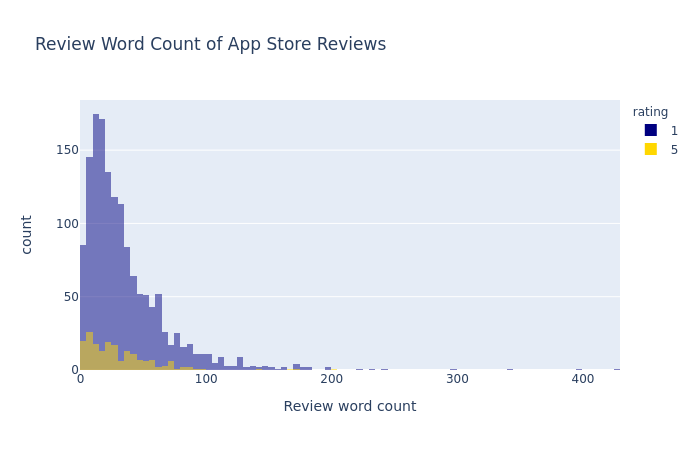

In [150]:
import plotly.io as pio
pio.renderers.default = "iframe"

# disable false positive warning
pd.options.mode.chained_assignment = None  # default='warn'

# init empty DF
ax = pd.DataFrame()

# Collect and store all App Store reviews in a temporary DF
ax = combined_df.loc[combined_df['type'] == 'app store']
ax['Review word count'] = ax['review'].str.count(' ') + 1

fig = px.histogram(
    ax, 
    x='Review word count',
    color='rating',
    color_discrete_sequence=['navy', 'gold'],
    title='Review Word Count of App Store Reviews',
    barmode='overlay',
    width=950,
    height=500
)
fig.show()

# for graph to persist outside session
fig.show(renderer="png")

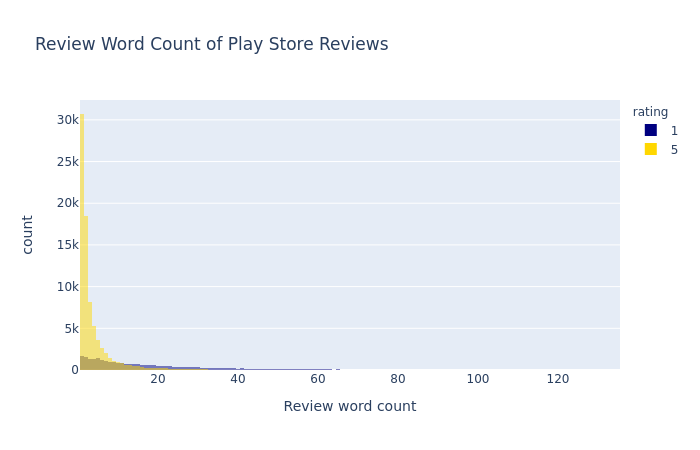

In [151]:
# init empty DF
bx = pd.DataFrame()

# Collect and store all Play Store reviews in a temporary DF
bx = combined_df.loc[combined_df['type'] == 'play store']
bx['Review word count'] = bx['review'].str.count(' ') + 1

fig = px.histogram(
    bx, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    color_discrete_sequence=['navy', 'gold'],
    title='Review Word Count of Play Store Reviews',
    barmode='overlay',
    width=950, 
    height=500
)
fig.show()

# for graph to persist outside session
fig.show(renderer="png")

## Convert plain text to bag-of-words (BOW)
---

In [15]:
import re
import nltk
import advertools as adv
from nltk import word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog'])

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Tokenize and lemmatize review data

In [204]:
import time
from sklearn.feature_extraction.text import CountVectorizer

data = []

test_df = combined_df.loc[combined_df['rating'] == 1]
data = test_df.review.values.tolist()
vocab_size = 2000

print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(
    input='content', 
    analyzer='word', 
    stop_words=stop_words,
    tokenizer=LemmaTokenizer(), 
    max_features=vocab_size, 
    max_df=0.98, 
    min_df=2
)

vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print(f'\nrows, words:\n{vectors.shape}')
print('\nDone. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.



vocab size: 2000

rows, words:
(30586, 2000)

Done. Time elapsed: 13.81s


In [33]:
# threshold = 5
# test = vectors

# for i in range(0, 10):
#     print(test[i].todense())
#     print(test[i].sum(axis=1))
# # test.sum(axis=1)>threshold
# # test[np.array(test.sum(axis=1)>threshold).reshape(-1,)]

### Remove reviews shorter than three words
Very short reviews won't be able to express more than a single topic

In [34]:
# print(f'Before:\n{vectors.shape}')

# threshold = 5
# test = test[np.array(test.sum(axis=1)>threshold).reshape(-1,)]
# print(f'\nAfter removing short reviews (<{threshold} words):')        
# print(test.shape)

# print(f'\n{type(test), test.dtype}')
# print(test[0])

In [35]:
# test[0].todense()

### Type-cast input dat to np.float32 since all the params (i.e. weights and biases) in the NTM model will also follow that format
This is a more optimal approach as opposed to repeatedly type-casting during mini-batch training

In [206]:
import scipy.sparse as sparse

vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)
print(vectors[:11])

<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 1898)	1.0
  (0, 1888)	1.0
  (0, 1918)	1.0
  (0, 1934)	1.0
  (0, 586)	1.0
  (1, 713)	1.0
  (1, 1200)	2.0
  (1, 315)	1.0
  (1, 945)	1.0
  (1, 129)	1.0
  (1, 154)	2.0
  (1, 282)	1.0
  (1, 1573)	1.0
  (2, 1074)	1.0
  (2, 1913)	1.0
  (2, 1594)	1.0
  (2, 1326)	1.0
  (2, 1332)	2.0
  (2, 1260)	1.0
  (3, 254)	1.0
  (3, 1904)	1.0
  (3, 1898)	1.0
  (3, 1280)	1.0
  (3, 1307)	1.0
  (3, 764)	1.0
  :	:
  (6, 1123)	1.0
  (6, 1737)	1.0
  (6, 39)	1.0
  (6, 140)	1.0
  (6, 1260)	1.0
  (6, 1265)	1.0
  (6, 1311)	1.0
  (6, 1107)	1.0
  (6, 1749)	1.0
  (6, 1336)	1.0
  (7, 752)	1.0
  (7, 1146)	1.0
  (7, 1174)	1.0
  (8, 1689)	1.0
  (8, 60)	1.0
  (8, 506)	1.0
  (8, 1524)	1.0
  (8, 1561)	1.0
  (8, 266)	1.0
  (8, 1077)	1.0
  (8, 1032)	1.0
  (8, 135)	1.0
  (8, 933)	1.0
  (9, 657)	1.0
  (10, 1038)	1.0


In [207]:
vectors[:11].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Split data to training (20%), validation (40%), and test (40%) datasets

In [208]:
n_train = int(0.2 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(6117, 2000) (12235, 2000) (12234, 2000)


### Store data in S3

In [209]:
# import os
# from sagemaker import get_execution_role

# role = get_execution_role()

# bucket = 'sagemaker-us-east-1-305262579855'
# prefix = 'sagemaker/regalado'

# train_prefix = os.path.join(prefix, 'train')
# valid_prefix = os.path.join(prefix, 'valid')
# output_prefix = os.path.join(prefix, 'output')

# s3_train_data = os.path.join('s3://', bucket, train_prefix)
# s3_valid_data = os.path.join('s3://', bucket, valid_prefix)
# output_path = os.path.join('s3://', bucket, output_prefix)
# print('Training set location', s3_train_data)
# print('Validation set location', s3_valid_data)
# print('\nTrained model will be saved at', output_path)

### Convert data into RecordIO Protobuf format using the SageMaker Python API

In [210]:
import scipy

# convert sparse CSR matrices to numpy arrays
train_vectors = scipy.sparse.csr_matrix.toarray(train_vectors)
val_vectors = scipy.sparse.csr_matrix.toarray(val_vectors)
test_vectors = scipy.sparse.csr_matrix.toarray(test_vectors)

In [211]:
import io
import boto3
import sagemaker
import datetime as dt
import sagemaker.amazon.common as smac

sesh = sagemaker.Session()
prefix = "sagemaker/regalado"
bucket = sesh.default_bucket()
curr_dtime = time.strftime("%Y%m%d-%H%M%S")

def convAndStore(dtype, key, vectors):
    # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
    
    # init memory buffer in RAM where data will be written
    buf = io.BytesIO()

    # write train data (numpy array) into a dense tensor 
    # smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
    smac.write_numpy_to_dense_tensor(buf, vectors)

    # sets the file's current position at the offset (0)
    # i.e. set the reference point to the beginning of the memory buffer
    buf.seek(0)
    
    # upload to s3
    key = str(key)
    

    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, dtype, key)).upload_fileobj(buf)
    s3_data = f"s3://{bucket}/{prefix}/{dtype}/{key}"
    
    print(f"Uploaded data at: {s3_data}")
    
    return s3_data
    
s3_train_data = convAndStore('train', curr_dtime, train_vectors)
s3_valid_data = convAndStore('valid', curr_dtime, val_vectors)
s3_test_data = convAndStore('test', curr_dtime, test_vectors)

Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/train/20210618-190616
Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/valid/20210618-190616
Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/test/20210618-190616


### Store data in S3

In [212]:
# import os
# import boto3

# def tos3(key, buf):
#     key = str(key)
#     prefix = "regalado"

#     boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
#     s3_data = f"s3://{bucket}/{prefix}/train/{key}"

#     print(f"Uploaded data at: {s3_data}")

# # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
# # then upload to s3
# tos3('train', toProtobuf(train_vectors))

### Convert data into RecordIO Protobuf format using the SageMaker Python API

In [213]:
# !pip install -U sagemaker

In [214]:
# import io
# import boto3
# import sagemaker
# import sagemaker.amazon.common as smac

# def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
#     chunk_size = sparray.shape[0]// n_parts
    
#     for i in range(n_parts):
#         # Calculate start and end indices
#         start = i*chunk_size
#         end = (i+1)*chunk_size
#         if i+1 == n_parts:
#             end = sparray.shape[0]
        
#         # Convert to record protobuf
#         buf = io.BytesIO()
#         smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
#         buf.seek(0)
        
#         # Upload to s3 location specified by bucket and prefix
#         fname = os.path.join(prefix, fname_template.format(i))
#         boto3.resource("s3").Bucket(bucket).Object(fname).upload_fileobj(buf)
#         print("Uploaded data to s3://{}".format(os.path.join(bucket, fname)))

In [215]:
# split_convert_upload(
#     train_vectors, bucket=bucket, prefix=train_prefix, fname_template="train_part{}.pbr", n_parts=8
# )
# split_convert_upload(
#     val_vectors, bucket=bucket, prefix=valid_prefix, fname_template="val_part{}.pbr", n_parts=1
# )

## Model training
---

### Set credentials

In [216]:
from sagemaker import tuner
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve

sesh = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name    
container = retrieve('ntm', region)
client = boto3.Session().client('sagemaker')
output_prefix = os.path.join(prefix, 'output')
output_path = os.path.join('s3://', bucket, output_prefix)

2021-06-18 19:06:29,834 | INFO | image_uris.py:162 | _config_for_framework_and_scope | Same images used for training and inference. Defaulting to image scope: inference.
2021-06-18 19:06:29,835 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: 1.
2021-06-18 19:06:29,846 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.


In [217]:
!pip install 'sagemaker[local]' --upgrade

In [218]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


In [219]:
ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge', # Free-tier instance
    output_path=output_path,
    sagemaker_session=sesh
)

In [220]:
num_topics = 2

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001,
#     mini_batch_size=128,
#     learning_rate=1e-4
)

## Base training
---

In [221]:
# ntm.fit(inputs={'train': s3_train_data, 'validation': s3_valid_data})

## Automatic Hyperparameter Tuning
---

In [222]:
hyperparameter_ranges = {
    'weight_decay': tuner.ContinuousParameter(0.1, 1.0),
    'mini_batch_size': tuner.IntegerParameter(16, 2048),
    'learning_rate': tuner.ContinuousParameter(1e-4, 0.1),
    'rescale_gradient': tuner.ContinuousParameter(0.1, 1.0),
    'optimizer': tuner.CategoricalParameter(['sgd', 'adam', 'adadelta']),
    'encoder_layers_activation': tuner.CategoricalParameter(['sigmoid', 'tanh', 'relu'])
}

objective_metric_name = 'validation:total_loss'

In [223]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    ntm,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=20,
    max_parallel_jobs=4
)

In [224]:
hyperparameter_tuner.fit(
    {'train': s3_train_data, 'validation': s3_valid_data},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

2021-06-18 19:06:35,535 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-18 19:06:35,547 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-18 19:06:35,548 | INFO | session.py:2050 | create_tuning_job | Creating hyperparameter tuning job with name: ntm-210618-1906


'InProgress'

In [225]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 6, 18, 19, 6, 35, 862000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/ntm-210618-1906',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:total_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [{'Name': 'optimizer',
                                                                                       'Values': ['sgd',
                                                                                                  'adam',
                                                                                                  'adadelta']},
                                                                                      {'Name': 'encoder_layers_activation',
                                     

In [226]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7f9f0ca63048>,
 'objective_metric_name': 'validation:total_loss',
 '_hyperparameter_ranges': {'weight_decay': <sagemaker.parameter.ContinuousParameter at 0x7f9ed2d338d0>,
  'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7f9ed2d33908>,
  'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7f9ed2d33940>,
  'rescale_gradient': <sagemaker.parameter.ContinuousParameter at 0x7f9ed2d33978>,
  'optimizer': <sagemaker.parameter.CategoricalParameter at 0x7f9ed2d339b0>,
  'encoder_layers_activation': <sagemaker.parameter.CategoricalParameter at 0x7f9ed2d339e8>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 12,
 'max_parallel_jobs': 3,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name':

In [227]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'ntm-210618-1906'

In [228]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [229]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

latest_df().sort_values('FinalObjectiveValue', ascending=True)

,encoder_layers_activation,learning_rate,mini_batch_size,optimizer,rescale_gradient,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,tanh,0.000666,128.0,adadelta,0.167666,0.851992,ntm-210618-1906-006-962ed015,Completed,6.117985,2021-06-18 19:14:52+00:00,2021-06-18 19:16:37+00:00,105.0
10,tanh,0.006702,99.0,adadelta,0.365883,0.762555,ntm-210618-1906-002-a3986ef5,Completed,6.118628,2021-06-18 19:09:12+00:00,2021-06-18 19:10:50+00:00,98.0
5,tanh,0.002238,1313.0,adadelta,0.308374,0.821038,ntm-210618-1906-007-5b81e66a,Completed,6.119612,2021-06-18 19:21:16+00:00,2021-06-18 19:23:39+00:00,143.0
1,sigmoid,0.016451,456.0,adam,0.620148,0.733806,ntm-210618-1906-011-8c740840,Completed,6.120365,2021-06-18 19:27:35+00:00,2021-06-18 19:29:12+00:00,97.0
3,sigmoid,0.002000,352.0,adadelta,0.360147,0.629629,ntm-210618-1906-009-94ee0cdb,Completed,6.123201,2021-06-18 19:23:20+00:00,2021-06-18 19:25:00+00:00,100.0
11,sigmoid,0.012907,37.0,adam,0.193915,0.275768,ntm-210618-1906-001-629ededf,Completed,6.127451,2021-06-18 19:09:13+00:00,2021-06-18 19:10:46+00:00,93.0
9,sigmoid,0.021123,101.0,sgd,0.914420,0.979202,ntm-210618-1906-003-79237791,Completed,6.127640,2021-06-18 19:09:38+00:00,2021-06-18 19:11:47+00:00,129.0
0,relu,0.000672,363.0,adadelta,0.946689,0.553511,ntm-210618-1906-012-a6ddb14a,Completed,6.127730,2021-06-18 19:28:28+00:00,2021-06-18 19:29:56+00:00,88.0
4,relu,0.076152,62.0,adam,0.221719,0.823427,ntm-210618-1906-008-5a4cede2,Completed,6.145584,2021-06-18 19:20:24+00:00,2021-06-18 19:21:52+00:00,88.0
8,tanh,0.002434,1062.0,sgd,0.793530,0.462444,ntm-210618-1906-004-d626ec26,Completed,6.222222,2021-06-18 19:14:05+00:00,2021-06-18 19:17:26+00:00,201.0


<!-- ### Specify how training and validation data will be distributed to the workers during training
ShardedByS3Key: data files will be sharded to different workers, that is, each worker will receive a different portion of the full data set. -->

In [651]:
# from sagemaker.inputs import TrainingInput

# s3_train = TrainingInput(s3_train_data, distribution="ShardedByS3Key") 
# s3_valid = TrainingInput(s3_valid_data) 

## Retrain model with the best hyperparameter values to instantiate an Estimator object required to deploy a SageMaker endpoint
---

In [230]:
import sagemaker

sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001,
    weight_decay=0.851992,
    mini_batch_size=128,
    learning_rate=0.000666,
    rescale_gradient=0.167666,
    optimizer='adadelta',
    encoder_layers_activation='tanh'
)

In [232]:
ntm.fit(inputs={"train": s3_train_data, "validation": s3_valid_data})

2021-06-18 19:34:18,648 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-18 19:34:18,659 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-18 19:34:18,660 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-18-19-34-18-647


2021-06-18 19:34:18 Starting - Starting the training job...
2021-06-18 19:34:33 Starting - Launching requested ML instancesProfilerReport-1624044858: InProgress
......
2021-06-18 19:35:47 Starting - Preparing the instances for training............
2021-06-18 19:37:34 Downloading - Downloading input data...
2021-06-18 19:38:14 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/18/2021 19:38:24 INFO 140529553360704] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid

In [233]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

2021-06-18 19:39:32,188 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-18-19-39-32-083
2021-06-18 19:39:33,013 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-18-19-39-32-083


-----------------!

In [127]:
# def recordio_protobuf_serializer(spmatrix):
#     import io
#     import sagemaker.amazon.common as smac

#     buf = io.BytesIO()
#     smac.write_spmatrix_to_sparse_tensor(array=spmatrix, file=buf, labels=None)
#     buf.seek(0)
#     return buf

# test = recordio_protobuf_serializer(test_vectors[:5])

In [234]:
test_vectors[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [257]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

results = predictor.predict(test_vectors[:5])
print(results)

{'predictions': [{'topic_weights': [0.4964951873, 0.5035048127]}, {'topic_weights': [0.4964951873, 0.5035048127]}, {'topic_weights': [0.4964951873, 0.5035048127]}, {'topic_weights': [0.4964951873, 0.5035048127]}, {'topic_weights': [0.4964951873, 0.5035048127]}]}


## Delete endpoint after performing inferences
---

In [260]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-18 19:50:58,116 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-18-19-39-32-083


In [258]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.49649519 0.50350481]
 [0.49649519 0.50350481]
 [0.49649519 0.50350481]
 [0.49649519 0.50350481]
 [0.49649519 0.50350481]]


Text(0.5, 0, 'Topic ID')

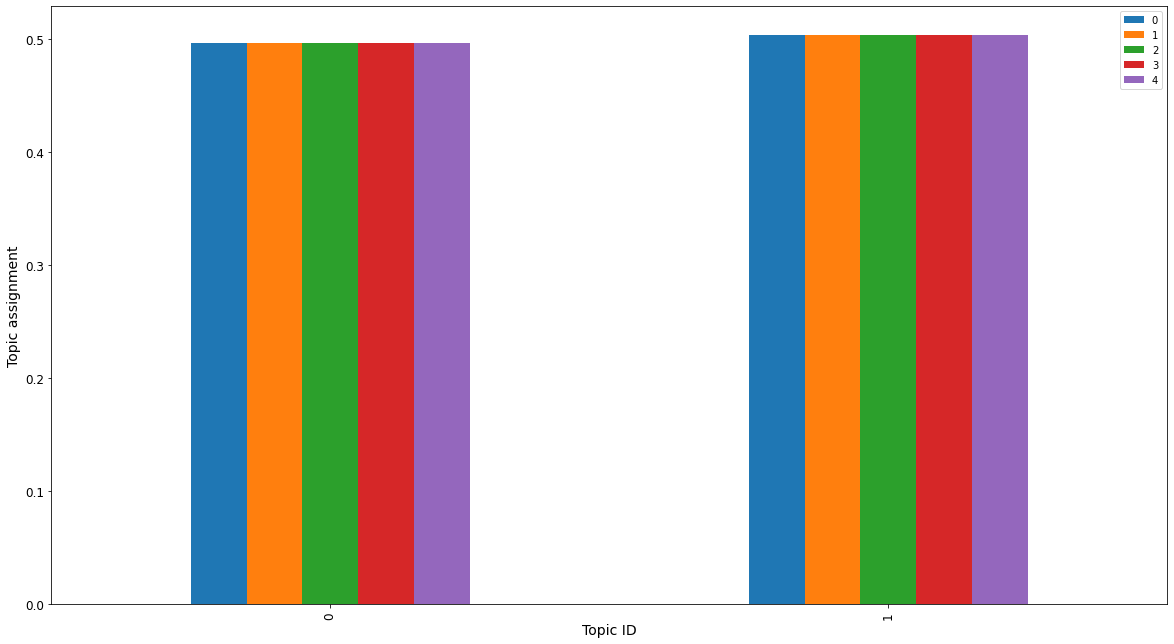

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [238]:
!{sys.executable} -m pip install mxnet
import mxnet as mx

## Load model artifacts stored in output directory
---

In [239]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-18-19-34-18-647/output/model.tar.gz'

In [240]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [241]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [242]:
import tarfile
tarfile.open('downloaded_model.tar.gz').extractall()

In [243]:
import zipfile
with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')

In [244]:
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

In [245]:
!{sys.executable} -m pip install wordcloud
import wordcloud as wc

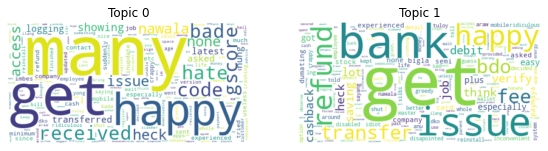

In [246]:
import matplotlib.pyplot as plt

word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 25
n_col = 4
counter = 0

plt.figure(figsize=(20, 16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = "Topic {}".format(ind)

    # pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)
    # plt.close()

    counter += 1